In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.gating.utilities import centroid, multi_centroid_calculation
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.neighbors import KDTree
from sklearn.cluster import DBSCAN, KMeans
from multiprocessing import Pool, cpu_count
from functools import partial
from itertools import cycle
from datetime import datetime
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
import os
warnings.filterwarnings('ignore')
test_init()

In [3]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [4]:
samples = exp.list_samples()

In [10]:
def visualise_manual_rect(sample_go, parent_population, x, y, x_min, x_max, y_min, y_max, xlim, ylim):
    data = sample_go.get_population_df(parent_population, transform=True, 
                                       transform_features=[x,y]).copy()
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    r = Rectangle(xy=(x_min, y_min), width=x_max, height=y_max, fill=False, edgecolor='r')
    ax.add_patch(r)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

In [69]:
hc = Gating(exp, 'hc19')

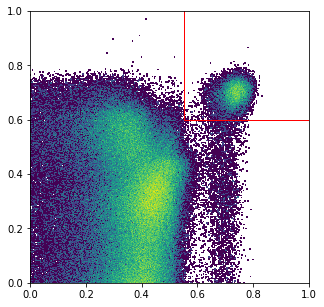

In [70]:
x_min, x_max, y_min, y_max = 0.55, 1.0, 0.6, 1
visualise_manual_rect(hc, 'manual_nongdt', 'Va7.2', 'CD161', x_min, x_max, y_min, y_max, 
                      xlim=(0,1), ylim=(0,1))

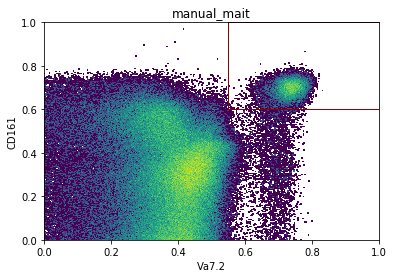

In [71]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_mait', definition='+')
child_populations.add_population('manual_classic', definition='-')

gate_definition = dict(x='Va7.2', y='CD161', x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
hc.create_gate(gate_name='manual_mait', parent='manual_nongdt', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)
hc.apply('manual_mait')

In [72]:
hc.save(overwrite=True)

Saved successfully!


True

In [87]:
for x in samples:
    hc = Gating(exp, x)
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('dbscan_maits', target=(0.7, 0.7), weight=1)
    child_populations.add_population('dbscan_classic', target=(0.2, 0.2), weight=1)
    gate_definition = dict(x='Va7.2', y='CD161', min_pop_size=100, distance_nn=0.03, frac=0.1)
    hc.create_gate(gate_name='dbscan_maits', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='dbscan', kwargs=gate_definition, child_populations=child_populations)
    hc.apply('dbscan_maits', plot_output=False)
    hc.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Expected 2 populations but found 1
Populations f['dbscan_maits', 'dbscan_classic'] assigned to the same cluster 0;prioritising dbscan_maits based on weighting.
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [88]:
for x in samples:
    hc = Gating(exp, x)
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('hdbscan_maits', target=(0.7, 0.7), weight=1)
    child_populations.add_population('hdbscan_classic', target=(0.2, 0.2), weight=1)
    gate_definition = dict(x='Va7.2', y='CD161', min_pop_size=100, frac=0.1)
    hc.create_gate(gate_name='hdbscan_maits', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
    hc.apply('hdbscan_maits', plot_output=False)
    hc.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [89]:
for x in samples:    
    hc = Gating(exp, x)
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_maits', definition='+')
    child_populations.add_population('gmm_classic', definition='-')
    gate_definition = dict(x='Va7.2', y='CD161', conf=0.99, k=5, target=(0.7, 0.7))
    hc.create_gate(gate_name='gmm_maits', parent='manual_liveCD3', class_='MixtureModel', 
                   method='gate', kwargs=gate_definition, child_populations=child_populations)
    hc.apply('gmm_maits', plot_output=False)
    hc.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [90]:
for x in samples:    
    hc = Gating(exp, x)
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_maits', definition='++')
    child_populations.add_population('dens2d_classic', definition=['--', '+-', '-+'])
    gate_definition = dict(x='Va7.2', y='CD161', kde_bw=0.1)
    hc.create_gate(gate_name='dens2d_maits', parent='manual_liveCD3', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    hc.apply('dens2d_maits', plot_output=False)
    hc.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
